# Section 4.3: Regression on Boston house price dataset

In [1]:
from tensorflow.keras.datasets import boston_housing

In [4]:
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()
print("train data shape: {}, test data shape: {}".format(train_data.shape, test_data.shape))
print(train_target[:10])

train data shape: (404, 13), test data shape: (102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [5]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std
test_data -= mean
test_data /= std

In [11]:
from tensorflow import keras
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

### K-fold validation

In [13]:
import numpy as np
k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []
for i in range(k):
    print("Processing fold {}".format(i))
    val_data = train_data[i*num_val_samples : (i + 1)*num_val_samples]
    val_target = train_target[i*num_val_samples : (i + 1)*num_val_samples]
    partial_train_data = np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i + 1)*num_val_samples:]
    ], axis = 0)
    partial_train_target = np.concatenate([
        train_target[:i*num_val_samples],
        train_target[(i + 1)*num_val_samples:]
    ], axis = 0)
    model = build_model()
    model.fit(partial_train_data, partial_train_target, epochs = num_epochs, batch_size = 1, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_target, verbose = 0)
    all_scores.append(val_mae)

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [14]:
print(all_scores)
print(np.mean(all_scores))

[2.4519744, 2.6298327, 2.5868893, 2.4225664]
2.5228157


### Train the model with 500 epochs and record the validation score each epoch

In [15]:
num_epochs = 500
all_mae_history = []
for i in range(k):
    print("Processing fold {}".format(i))
    val_data = train_data[i*num_val_samples : (i + 1)*num_val_samples]
    val_target = train_target[i*num_val_samples : (i + 1)*num_val_samples]
    partial_train_data = np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i + 1)*num_val_samples:]
    ], axis = 0)
    partial_train_target = np.concatenate([
        train_target[:i*num_val_samples],
        train_target[(i + 1)*num_val_samples:]
    ], axis = 0)
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_target, 
                        epochs = num_epochs, 
                        batch_size = 1, 
                        verbose = 0,
                        validation_data = (val_data, val_target)
                       )
    all_mae_history.append(history.history['val_mae'])

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [17]:
mae_history = np.array(all_mae_history)
print(mae_history.shape)

(4, 500)


In [19]:
mae_average = mae_history.mean(axis = 0)
print(mae_average.shape)

(500,)


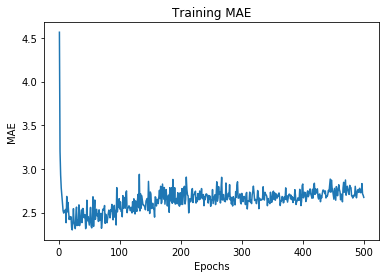

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(mae_average) + 1), mae_average)
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training MAE")
plt.show()

The chart is hard to see. We do the following:  
    - Omit 10 first points since they are in difference scale than the rest  
    - Replace each point with an exponential moving average of the previous point to obtain smooth curve. 

In [21]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(factor * previous + (1 - factor) * point)
        else:
            smoothed_points.append(point)
    return np.array(smoothed_points)

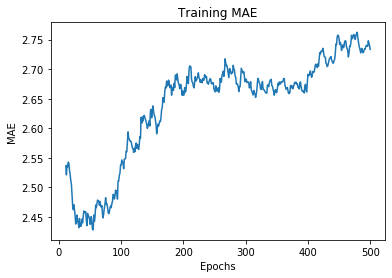

MAE reach minimum at: 21
MAE minimum value: 2.3018810749053955


In [28]:
plt.plot(range(11, len(mae_average) + 1), smooth_curve(mae_average[10:]))
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training MAE")
plt.show()
print("MAE reach minimum at: {}".format(np.argmin(mae_average)))
print("MAE minimum value: {}".format(np.min(mae_average)))

### Train the final model

In [30]:
model = build_model()
model.fit(train_data, train_target, epochs = 80, batch_size = 16, verbose = 0)
mse_score, mae_score = model.evaluate(test_data, test_target, verbose = 0)
print("MSE score = {}, MAE score = {}".format(mse_score, mae_score))

MSE score = 17.657101500268077, MAE score = 2.650527000427246


In [36]:
#predict:
predictions = model.predict(test_data)
print("Prediction 0-10: \n{}".format(predictions[0:10].T))
print("Target 0 - 10: \n{}".format(test_target[0:10]))

Prediction 0-10: 
[[ 7.055311 18.390923 21.019272 31.397491 24.429825 20.578266 25.25946
  20.883194 19.122303 21.382877]]
Target 0 - 10: 
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]
